# Compose: Training a model to generate music

In [2]:
import os
import pickle
import numpy
from music21 import note, chord

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

from models.RNNAttention import get_distinct, create_lookups, prepare_sequences, get_music_list, create_network

## Set parameters

In [3]:
# run params
section = 'compose'
run_id = '0006'
music_name = 'cello'

run_folder = 'run/{}/'.format(section)
run_folder += '_'.join([run_id, music_name])


store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join('data', music_name)

if not os.path.exists(run_folder):
    os.mkdir(run_folder)
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))
    


mode = 'build' # 'load' # 

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True

## Extract the notes

In [4]:
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        

        for interval in intervals:

            score = original_score.transpose(interval)

            notes.extend(['START'] * seq_len)
            durations.extend([0]* seq_len)

            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))
                        durations.append(element.duration.quarterLength)

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f) 
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f) 

6 files in total
1 Parsing data\cello\cs1-1pre.mid
2 Parsing data\cello\cs1-2all.mid
3 Parsing data\cello\cs1-3cou.mid
4 Parsing data\cello\cs1-4sar.mid
5 Parsing data\cello\cs1-5men.mid
6 Parsing data\cello\cs1-6gig.mid


## Create the lookup tables

In [5]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [6]:
print('\nnote_to_int')
note_to_int


note_to_int


{'A2': 0,
 'A2.B2': 1,
 'A2.D3': 2,
 'A2.E-3': 3,
 'A2.E3.A3': 4,
 'A2.E3.C4': 5,
 'A3': 6,
 'B-2': 7,
 'B-3': 8,
 'B2': 9,
 'B2.C3': 10,
 'B2.D3': 11,
 'B3': 12,
 'C#2': 13,
 'C#3': 14,
 'C#4': 15,
 'C2': 16,
 'C2.G2.E3': 17,
 'C3': 18,
 'C3.D3': 19,
 'C4': 20,
 'D2': 21,
 'D2.A2.F#3': 22,
 'D2.A2.F#3.C4': 23,
 'D3': 24,
 'D3.A3': 25,
 'D4': 26,
 'E-2': 27,
 'E-3': 28,
 'E-4': 29,
 'E2': 30,
 'E3': 31,
 'E3.A3': 32,
 'E3.B3': 33,
 'E3.F3': 34,
 'E4': 35,
 'F#2': 36,
 'F#3': 37,
 'F#4': 38,
 'F2': 39,
 'F3': 40,
 'F4': 41,
 'G#2': 42,
 'G#3': 43,
 'G2': 44,
 'G2.B3.G4': 45,
 'G2.D3.B3': 46,
 'G2.E3.B3': 47,
 'G2.E3.C4': 48,
 'G2.G3': 49,
 'G3': 50,
 'G4': 51,
 'START': 52}

In [7]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 0.25: 1,
 0.5: 2,
 Fraction(2, 3): 3,
 0.75: 4,
 1.0: 5,
 1.25: 6,
 1.5: 7,
 2.0: 8,
 3.0: 9,
 4.0: 10}

## Prepare the sequences used by the Neural Network

In [8]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

In [9]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])

pitch input
[52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52 52
 52 52 52 52 52 52 52 52]
duration input
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pitch output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0.]
duration output
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Create the structure of the neural network

In [10]:
model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    5300        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    1100        input_2[0][0]                    
______________________________________________________________________________________________

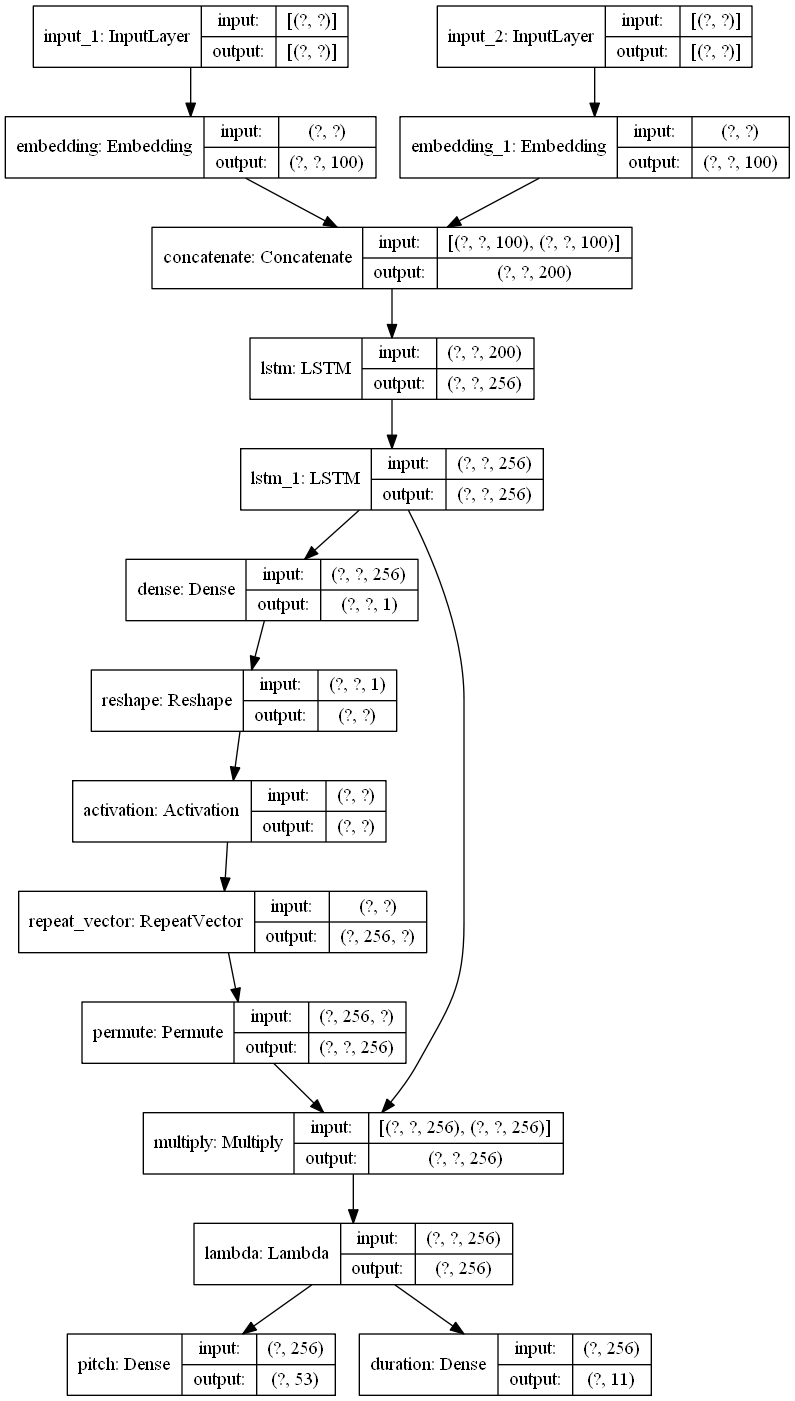

In [14]:
#Currently errors in TF2.2
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

## Train the neural network

In [12]:
weights_folder = os.path.join(run_folder, 'weights')
# model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [13]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
model.fit(network_input, network_output
          , epochs=2000000, batch_size=32
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )



Train on 3091 samples, validate on 773 samples
Epoch 1/2000000
3091/3091 [==============================] - 17s 6ms/sample - loss: 3.6784 - pitch_loss: 2.9793 - duration_loss: 0.6978 - val_loss: 3.8484 - val_pitch_loss: 3.0395 - val_duration_loss: 0.7939
Epoch 2/2000000
3091/3091 [==============================] - 2s 802us/sample - loss: 3.3722 - pitch_loss: 2.8347 - duration_loss: 0.5367 - val_loss: 3.7268 - val_pitch_loss: 2.9770 - val_duration_loss: 0.7382
Epoch 3/2000000
3091/3091 [==============================] - 2s 789us/sample - loss: 3.2640 - pitch_loss: 2.7784 - duration_loss: 0.4898 - val_loss: 3.7173 - val_pitch_loss: 2.9572 - val_duration_loss: 0.7527
Epoch 4/2000000
3091/3091 [==============================] - 2s 797us/sample - loss: 3.2015 - pitch_loss: 2.7365 - duration_loss: 0.4641 - val_loss: 3.7274 - val_pitch_loss: 2.9786 - val_duration_loss: 0.7411
Epoch 5/2000000
3091/3091 [==============================] - 2s 768us/sample - loss: 3.1485 - pitch_loss: 2.7090 - dur

Epoch 40/2000000
3091/3091 [==============================] - 2s 787us/sample - loss: 0.5653 - pitch_loss: 0.4985 - duration_loss: 0.0674 - val_loss: 5.0326 - val_pitch_loss: 3.8853 - val_duration_loss: 1.2385
Epoch 41/2000000
3091/3091 [==============================] - 2s 798us/sample - loss: 0.5105 - pitch_loss: 0.4491 - duration_loss: 0.0608 - val_loss: 5.1845 - val_pitch_loss: 3.9476 - val_duration_loss: 1.3235
Epoch 42/2000000
3091/3091 [==============================] - 2s 767us/sample - loss: 0.5000 - pitch_loss: 0.4414 - duration_loss: 0.0598 - val_loss: 5.2250 - val_pitch_loss: 3.9749 - val_duration_loss: 1.2729
Epoch 43/2000000
3091/3091 [==============================] - 2s 762us/sample - loss: 0.4694 - pitch_loss: 0.4043 - duration_loss: 0.0648 - val_loss: 4.8961 - val_pitch_loss: 3.6455 - val_duration_loss: 1.2647
Epoch 44/2000000
3091/3091 [==============================] - 2s 779us/sample - loss: 0.4464 - pitch_loss: 0.3918 - duration_loss: 0.0543 - val_loss: 5.5262 - v

3091/3091 [==============================] - 2s 742us/sample - loss: 0.1772 - pitch_loss: 0.1496 - duration_loss: 0.0273 - val_loss: 7.0185 - val_pitch_loss: 5.3209 - val_duration_loss: 1.7161
Epoch 80/2000000
3091/3091 [==============================] - 2s 781us/sample - loss: 0.1742 - pitch_loss: 0.1463 - duration_loss: 0.0286 - val_loss: 6.6874 - val_pitch_loss: 5.1105 - val_duration_loss: 1.6259
Epoch 81/2000000
3091/3091 [==============================] - 2s 789us/sample - loss: 0.1518 - pitch_loss: 0.1239 - duration_loss: 0.0279 - val_loss: 6.6199 - val_pitch_loss: 5.0368 - val_duration_loss: 1.6308
Epoch 82/2000000
3091/3091 [==============================] - 2s 766us/sample - loss: 0.1679 - pitch_loss: 0.1389 - duration_loss: 0.0287 - val_loss: 6.7971 - val_pitch_loss: 5.1446 - val_duration_loss: 1.6935
Epoch 83/2000000
3091/3091 [==============================] - 2s 772us/sample - loss: 0.1739 - pitch_loss: 0.1437 - duration_loss: 0.0297 - val_loss: 6.6232 - val_pitch_loss: 5.

3091/3091 [==============================] - 2s 767us/sample - loss: 0.0941 - pitch_loss: 0.0801 - duration_loss: 0.0138 - val_loss: 7.8766 - val_pitch_loss: 6.0076 - val_duration_loss: 2.0123
Epoch 119/2000000
3091/3091 [==============================] - 2s 761us/sample - loss: 0.0965 - pitch_loss: 0.0804 - duration_loss: 0.0157 - val_loss: 7.8230 - val_pitch_loss: 5.8200 - val_duration_loss: 2.1309
Epoch 120/2000000
3091/3091 [==============================] - 2s 750us/sample - loss: 0.0939 - pitch_loss: 0.0757 - duration_loss: 0.0179 - val_loss: 7.8538 - val_pitch_loss: 5.9590 - val_duration_loss: 2.0448
Epoch 121/2000000
3091/3091 [==============================] - 2s 772us/sample - loss: 0.0840 - pitch_loss: 0.0658 - duration_loss: 0.0185 - val_loss: 7.9196 - val_pitch_loss: 5.9426 - val_duration_loss: 2.1031
Epoch 122/2000000
3091/3091 [==============================] - 2s 759us/sample - loss: 0.0829 - pitch_loss: 0.0662 - duration_loss: 0.0164 - val_loss: 8.0064 - val_pitch_loss

In [ ]:
show